
# 2024 Revenue Analysis (Ontario) — Jupyter Notebook


It also generates:
- Revenue vs Time graph  
- Power x Price interaction graph  



In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [2]:

import pandas as pd

def is_winter(month: int) -> bool:
    # Winter schedule months: Nov-Apr
    return month in (11, 12, 1, 2, 3, 4)

def tou_period_for_row(ts_hour: int, month: int, weekday: int, is_weekend_offpeak=True) -> str:
    '''
    Determine the TOU period for a given hour/month/weekday.
    weekday: Monday=0,...,Sunday=6 (pandas convention)
    '''
    if weekday >= 5:  # Saturday=5, Sunday=6
        return "Off-Peak" if is_weekend_offpeak else "Weekday-Only"
    if is_winter(month):
        # Winter weekday windows
        if 7 <= ts_hour < 11:
            return "On-Peak"
        elif 11 <= ts_hour < 17:
            return "Mid-Peak"
        elif 17 <= ts_hour < 19:
            return "On-Peak"
        else:
            return "Off-Peak"
    else:
        # Summer weekday windows
        if 11 <= ts_hour < 17:
            return "On-Peak"
        elif (7 <= ts_hour < 11) or (17 <= ts_hour < 19):
            return "Mid-Peak"
        else:
            return "Off-Peak"

def price_cents(timestamp: pd.Timestamp, period: str) -> float:
    '''
    Return the price (cents/kWh) for the period at the given timestamp.
    - Jan 1 - Oct 31, 2024: Off 9.8, Mid 15.7, On 20.3
    - Nov 1 - Dec 31, 2024: Off 7.6, Mid 12.2, On 15.8
    '''
    cutoff = pd.Timestamp("2024-11-01 00:00:00")
    if timestamp < cutoff:
        if period == "Off-Peak":
            return 9.8
        elif period == "Mid-Peak":
            return 15.7
        else:
            return 20.3
    else:
        if period == "Off-Peak":
            return 7.6
        elif period == "Mid-Peak":
            return 12.2
        else:
            return 15.8

def ensure_energy_kWh(df: pd.DataFrame, dt_col: str):
    '''
    Ensure an "energy_kWh" column exists:
    1) If an "Energy" column exists:
       - Convert from Joules if large (median > 1e6)
       - Otherwise assume kWh
    2) Else derive from first available "Power" column:
       - Detect timestep from datetime diffs (median)
        - Infer units by median magnitude (W, kW, MW)
    Returns: (df, timestep_hours, note)
    '''
    # Detect timestep in hours
    if len(df) > 1:
        diffs = df[dt_col].diff().dropna().dt.total_seconds() / 3600.0
        timestep_hours = float(diffs.median())
        if timestep_hours <= 0:
            timestep_hours = 1.0
    else:
        timestep_hours = 1.0

    note = ""

    # Prefer an 'Energy' column exactly (case-insensitive match)
    e_cols = [c for c in df.columns if c.lower() == "energy"]
    if e_cols:
        e_col = e_cols[0]
        med = df[e_col].dropna().median()
        med = 0 if pd.isna(med) else med
        if med > 1e6:
            # Joules -> kWh
            df["energy_kWh"] = df[e_col] / 3.6e6
            note = "Converted '{}' from Joules to kWh.".format(e_col)
            return df, timestep_hours, note
        elif med > 0:
            # Assume already kWh
            df["energy_kWh"] = df[e_col]
            note = "Used '{}' as kWh.".format(e_col)
            return df, timestep_hours, note

    # Else derive from a power column
    p_cols_exact = [c for c in df.columns if c.lower() == "power"]
    p_cols_any   = [c for c in df.columns if "power" in c.lower()]
    p_col = p_cols_exact[0] if p_cols_exact else (p_cols_any[0] if p_cols_any else None)
    if p_col is None:
        raise RuntimeError("No usable Energy or Power column found to compute energy_kWh.")

    medp = df[p_col].dropna().median()
    medp = 0 if pd.isna(medp) else medp

    if medp > 100000:          # likely W
        df["energy_kWh"] = (df[p_col] / 1000.0) * timestep_hours
        note = "Derived energy from '{}' in Watts with {:.2f} h.".format(p_col, timestep_hours)
    elif 1 < medp < 3000:      # likely MW
        df["energy_kWh"] = (df[p_col] * 1000.0) * timestep_hours
        note = "Derived energy from '{}' in MW with {:.2f} h.".format(p_col, timestep_hours)
    elif 1e3 < medp < 1e6:     # likely kW
        df["energy_kWh"] = df[p_col] * timestep_hours
        note = "Derived energy from '{}' in kW with {:.2f} h.".format(p_col, timestep_hours)
    else:
        # Fallback assume MW
        df["energy_kWh"] = (df[p_col] * 1000.0) * timestep_hours
        note = "Derived energy from '{}' (assumed MW) with {:.2f} h.".format(p_col, timestep_hours)

    return df, timestep_hours, note


In [3]:

# Load the master hourly CSV
assert Path("../clean/Merged_hourly_data.csv").exists(), "Input CSV not found at: clean/Merged_hourly_data.csv"

df = pd.read_csv("../clean/Merged_hourly_data.csv")

# Identify a datetime column or build it from Date/Time
dt_candidates = ["datetime", "Datetime", "date_time", "DateTime", "DATE_TIME", "DATE", "Date"]
dt_col = None
for c in dt_candidates:
    if c in df.columns:
        dt_col = c
        break

if dt_col is None and {"Date","Time"}.issubset(set(df.columns)):
    df["datetime"] = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"].astype(str), errors="coerce")
    dt_col = "datetime"
elif dt_col is None:
    raise RuntimeError("No datetime column found and no (Date, Time) columns to combine.")

df[dt_col] = pd.to_datetime(df[dt_col], errors="coerce")
df = df.dropna(subset=[dt_col]).copy()
df = df.sort_values(dt_col).reset_index(drop=True)

# Basic time columns
df["hour"]    = df[dt_col].dt.hour
df["weekday"] = df[dt_col].dt.weekday     # Monday=0..Sunday=6
df["month"]   = df[dt_col].dt.month
df["date"]    = df[dt_col].dt.date

df.head()


,Unnamed: 0,Station Name_Cornwall,Station Code_Cornwall,Date_Cornwall,Time_Cornwall,DateTime,Water Level (meters) - Niveau d'eau (mètres)_Cornwall,"Discharge (cubic meters per second) - Débit (mètres cubes par seconde), Q",Station Name_LSD,Station Code_LSD,...,"hydraulic_head, h",overflow,Power (Watts),"hour, Hourly",seconds,Energy (Joules),hour,weekday,month,date
0,0,Cornwall,14870,2024-01-01,00:00,2024-01-01 00:00:00,0.410,261000.0,Long Sault Dam,14805,...,26.070,1.070,6.661639e+10,1,3600,2.398190e+14,0,0,1,2024-01-01
1,1,Cornwall,14870,2024-01-01,01:00,2024-01-01 01:00:00,0.412,261000.0,Long Sault Dam,14805,...,26.068,1.068,6.661128e+10,2,7200,4.796012e+14,1,0,1,2024-01-01
2,2,Cornwall,14870,2024-01-01,02:00,2024-01-01 02:00:00,0.411,261000.0,Long Sault Dam,14805,...,26.059,1.059,6.658828e+10,3,10800,7.191534e+14,2,0,1,2024-01-01
3,3,Cornwall,14870,2024-01-01,03:00,2024-01-01 03:00:00,0.414,261000.0,Long Sault Dam,14805,...,26.056,1.056,6.658061e+10,4,14400,9.587609e+14,3,0,1,2024-01-01
4,4,Cornwall,14870,2024-01-01,04:00,2024-01-01 04:00:00,0.416,261000.0,Long Sault Dam,14805,...,26.054,1.054,6.657550e+10,5,18000,1.198359e+15,4,0,1,2024-01-01


In [4]:

# Ensure energy in kWh
df, timestep_hours, energy_note = ensure_energy_kWh(df, dt_col)
timestep_hours, energy_note


(1.0, "Derived energy from 'Power (Watts)' in Watts with 1.00 h.")

In [5]:

# Apply TOU period and prices
df["TOU_period"] = [tou_period_for_row(h, m, w) for h, m, w in zip(df["hour"], df["month"], df["weekday"])]
df["TOU_price_cents_per_kWh"] = [price_cents(ts, per) for ts, per in zip(df[dt_col], df["TOU_period"])]
df["TOU_price_$per_kWh"] = df["TOU_price_cents_per_kWh"] / 100.0

df[["TOU_period", "TOU_price_cents_per_kWh", "TOU_price_$per_kWh"]].head()


,TOU_period,TOU_price_cents_per_kWh,TOU_price_$per_kWh
0,Off-Peak,9.8,0.098
1,Off-Peak,9.8,0.098
2,Off-Peak,9.8,0.098
3,Off-Peak,9.8,0.098
4,Off-Peak,9.8,0.098


In [6]:

# Revenue computations
df["revenue_hourly_$"] = df["energy_kWh"] * df["TOU_price_$per_kWh"]
daily_rev = df.groupby("date", as_index=False)["revenue_hourly_$"].sum().rename(columns={"revenue_hourly_$":"revenue_daily_$"})
total_revenue = float(df["revenue_hourly_$"].sum())
total_revenue


74202412069.54646

In [7]:

# Save updated CSVs

df.to_csv("../clean/Merged_hourly_data_with_revenue.csv", index=False)
daily_rev.to_csv("../clean/daily_revenue_2024.csv", index=False)




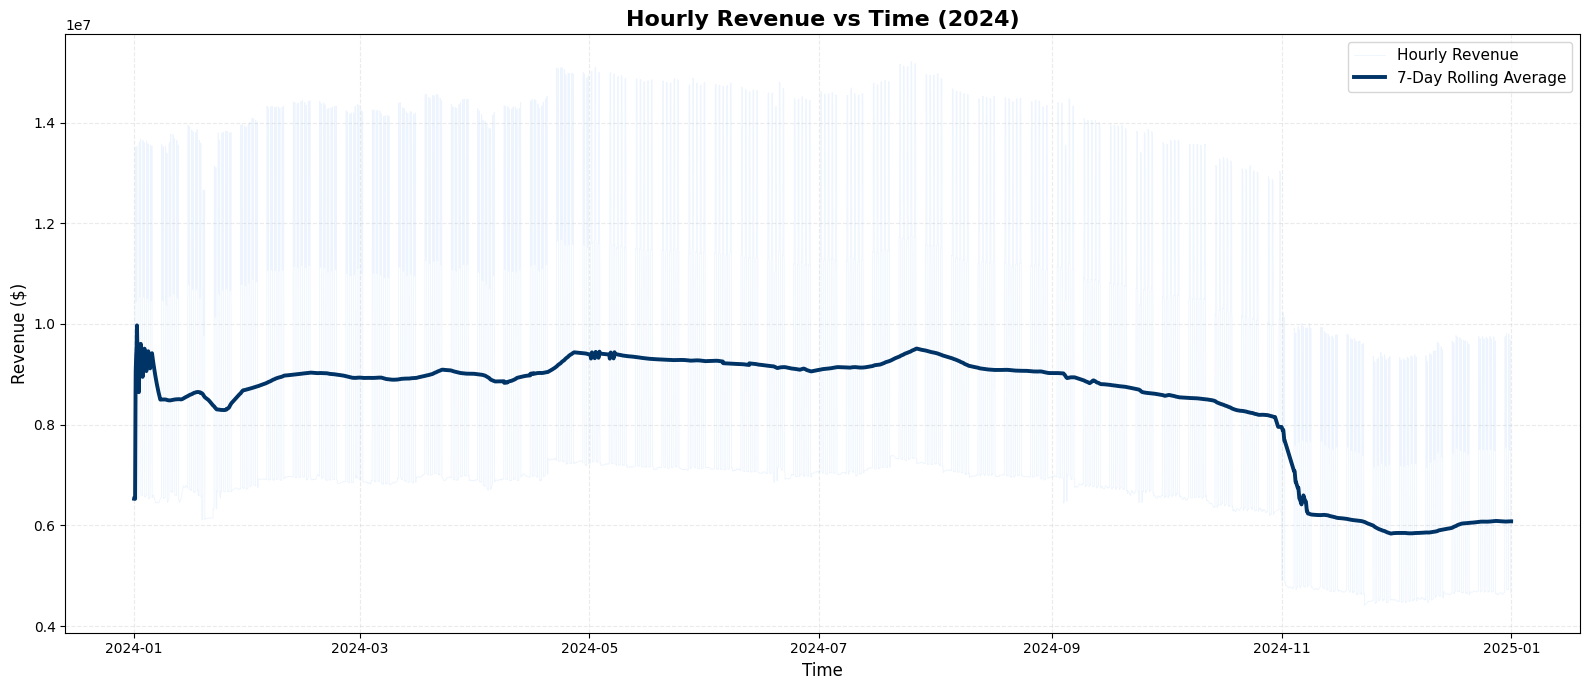

In [8]:

# Revenue vs Time
plt.figure(figsize=(16,7))

# Light hourly revenue background
plt.plot(
    df[dt_col], df["revenue_hourly_$"],
    color="#89BBF5",
    alpha=0.15,
    linewidth=0.6,
    label="Hourly Revenue"
)


rolling = (
    df.set_index(dt_col)["revenue_hourly_$"]
      .rolling("7D", min_periods=1)
      .mean()
)

plt.plot(
    rolling.index, rolling.values,
    color="#003366",
    linewidth=2.8,
    label="7-Day Rolling Average"
)


plt.xlabel("Time", fontsize=12)
plt.ylabel("Revenue ($)", fontsize=12)
plt.title("Hourly Revenue vs Time (2024)", fontsize=16, weight="bold")

plt.grid(alpha=0.25, linestyle="--")
plt.tight_layout()

plt.legend(frameon=True, facecolor="white", fontsize=11)
plt.savefig("../images/revenue_vs_time.png", dpi=250)
plt.show()


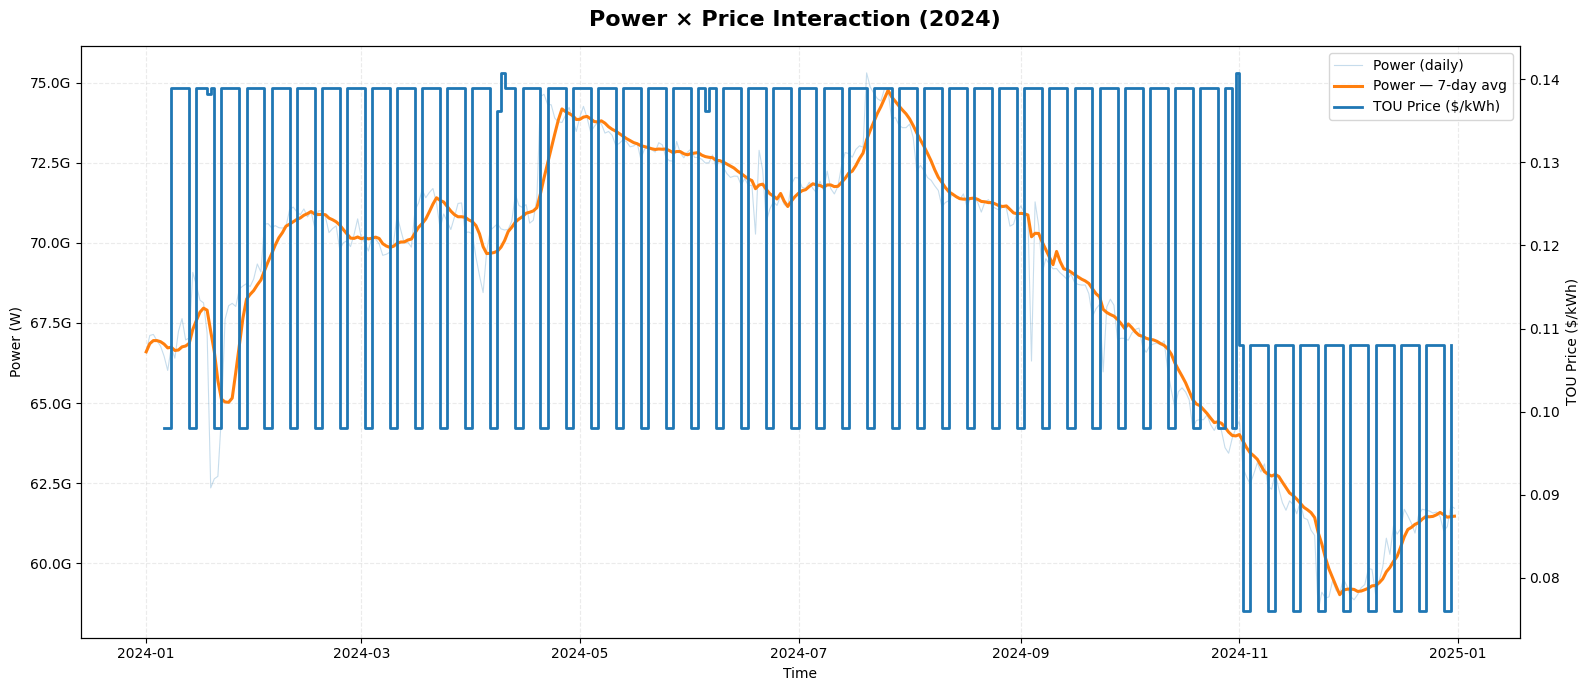

In [9]:

# Power × Price Interaction
power_col = next((c for c in df.columns if "power" in c.lower()), None)

if power_col:
    dfi = df.set_index(dt_col).sort_index()

    power_daily = dfi[power_col].resample("D").mean()
    power_roll = power_daily.rolling(7, min_periods=1).mean()

    price_daily = dfi["TOU_price_$per_kWh"].resample("D").mean()

    price_changes = price_daily[price_daily.ne(price_daily.shift(fill_value=price_daily.iloc[0]))]

    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter

    fig, ax1 = plt.subplots(figsize=(16,7))

    # ---- POWER (left axis) ----

    ax1.plot(power_daily.index, power_daily.values, alpha=0.25, linewidth=0.8, label="Power (daily)")

    ax1.plot(power_roll.index, power_roll.values, linewidth=2.2, label="Power — 7-day avg")

    ax1.set_xlabel("Time")
    ax1.set_ylabel("Power (W)")
    ax1.grid(alpha=0.25, linestyle="--")

    # nicer y-format (e.g., 7.1e9 → 7.1 G)
    def si_fmt(x, _):
        for unit in ["", "k", "M", "G", "T"]:
            if abs(x) < 1000.0:
                return f"{x:,.1f}{unit}"
            x /= 1000.0
        return f"{x:,.1f}P"
    ax1.yaxis.set_major_formatter(FuncFormatter(si_fmt))

    # ---- PRICE (right axis) ----
    ax2 = ax1.twinx()

    ax2.step(
        price_changes.index, price_changes.values,
        where="post", linewidth=2.0, label="TOU Price ($/kWh)"
    )
    ax2.set_ylabel("TOU Price ($/kWh)")


    fig.suptitle("Power × Price Interaction (2024)", fontsize=16, weight="bold")

    # single combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right", frameon=True, facecolor="white")

    fig.tight_layout()
    plt.savefig("../images/power_price_interaction.png", dpi=250)
    plt.show()
else:
    print("No power column found; skipping Power × Price plot.")


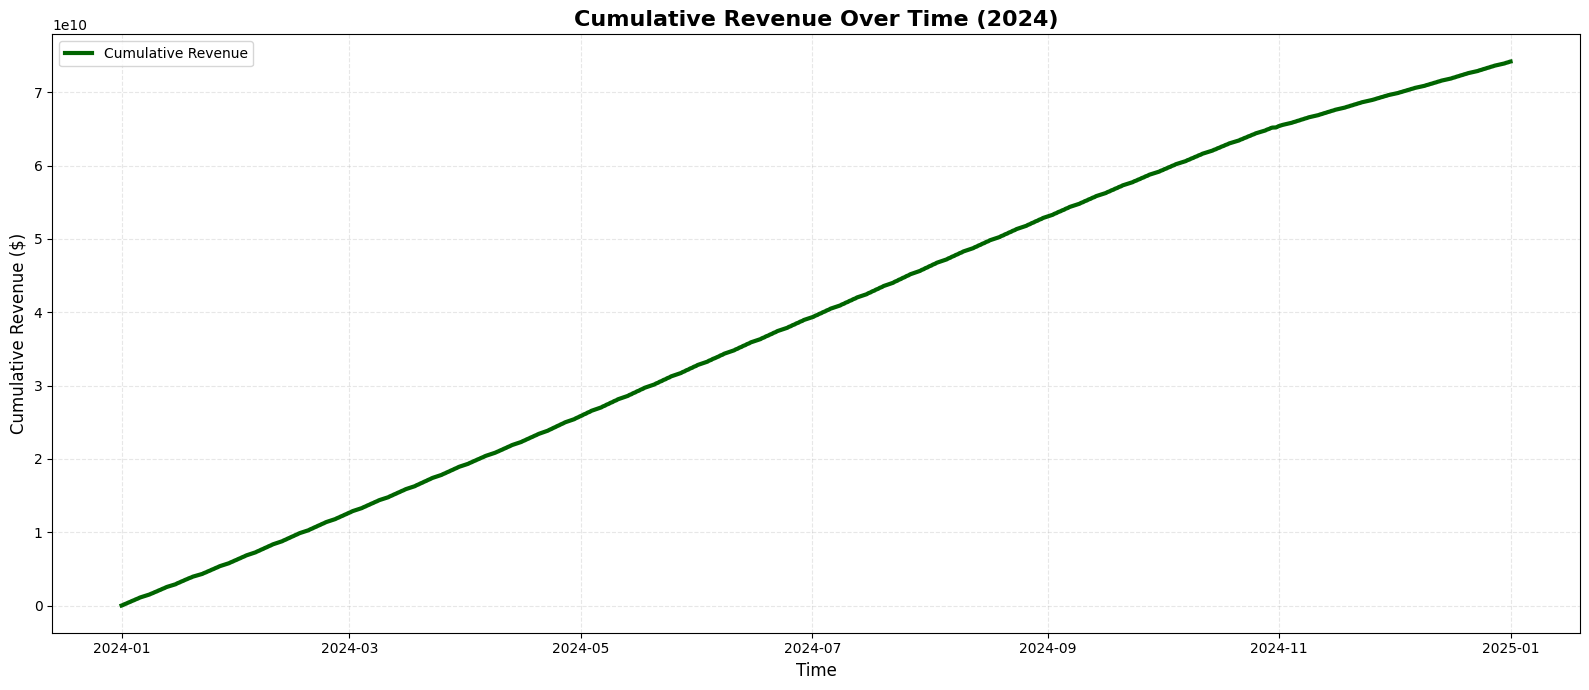

In [11]:
df = df.sort_values(dt_col)
df["cumulative_revenue"] = df["revenue_hourly_$"].cumsum()
plt.figure(figsize=(16,7))

plt.plot(
    df[dt_col], 
    df["cumulative_revenue"], 
    color="darkgreen",
    linewidth=3,
    label="Cumulative Revenue"
)

plt.xlabel("Time", fontsize=12)
plt.ylabel("Cumulative Revenue ($)", fontsize=12)
plt.title("Cumulative Revenue Over Time (2024)", fontsize=16, weight="bold")
plt.grid(alpha=0.3, linestyle="--")
plt.legend()
plt.tight_layout()
plt.savefig("../images/cumulative_revenue_over_time.png", dpi=250)
plt.show()

